<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-required-libraries-and-set-configurations" data-toc-modified-id="Import-required-libraries-and-set-configurations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import required libraries and set configurations</a></span></li><li><span><a href="#Import-required-dataset" data-toc-modified-id="Import-required-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import required dataset</a></span></li><li><span><a href="#Train/Test-split" data-toc-modified-id="Train/Test-split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train/Test split</a></span></li><li><span><a href="#Specify-X-and-y-for-train-and-test" data-toc-modified-id="Specify-X-and-y-for-train-and-test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Specify X and y for train and test</a></span></li><li><span><a href="#Feature-selection" data-toc-modified-id="Feature-selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature selection</a></span></li><li><span><a href="#Scale-the-appropriate-columns" data-toc-modified-id="Scale-the-appropriate-columns-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Scale the appropriate columns</a></span></li><li><span><a href="#Model-build" data-toc-modified-id="Model-build-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Model build</a></span><ul class="toc-item"><li><span><a href="#Ridge" data-toc-modified-id="Ridge-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Stacking" data-toc-modified-id="Stacking-7.6"><span class="toc-item-num">7.6&nbsp;&nbsp;</span>Stacking</a></span></li></ul></li><li><span><a href="#Model-results" data-toc-modified-id="Model-results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Model results</a></span></li><li><span><a href="#Model-analysis" data-toc-modified-id="Model-analysis-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model analysis</a></span><ul class="toc-item"><li><span><a href="#Analysis-of-features-of-best-model" data-toc-modified-id="Analysis-of-features-of-best-model-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Analysis of features of best model</a></span></li><li><span><a href="#Analysis-of-hyperparameters-of-best-model" data-toc-modified-id="Analysis-of-hyperparameters-of-best-model-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Analysis of hyperparameters of best model</a></span></li></ul></li></ul></div>

### Import required libraries and set configurations

In [1]:
# Import required libraries
import os
import swifter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from xgboost import plot_importance
from lightgbm import LGBMRegressor
from dask.distributed import Client
from dask_searchcv import GridSearchCV as dgcv
from dask.diagnostics import ProgressBar
from sklearn.model_selection import GridSearchCV as sgcv
from sklearn.ensemble import RandomForestRegressor
from sklearn .linear_model import Ridge
from sklearn.svm import SVR
from sklearn.externals import joblib
from sklearn.externals.joblib import parallel_backend
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold

In [3]:
# Set configuration variables
%matplotlib inline
plt.style.use('seaborn-notebook')
DATA_OUTPUT = '../data/processed/'
MODEL_OUTPUT = '../models/'
client = Client()

In [4]:
# Evaluation metric
def rmse(y_true, y_pred):
    '''Function to calculate root mean square error'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return(np.sqrt(mean_squared_error(y_true, y_pred)))

In [5]:
def mape(y_true, y_pred): 
    '''Function to calculate mean absolute percent error'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
def display_metrics(y_train_true, y_train_pred, y_test_true, y_test_pred):
    '''Function to display rmse and mape of train and test'''
    rmse_train = rmse(y_train_true, y_train_pred)
    rmse_test = rmse(y_test_true, y_test_pred)
    mape_train = mape(y_train_true, y_train_pred)
    mape_test = mape(y_test_true, y_test_pred)
    
    print('RMSE of train is : ', rmse_train)
    print('RMSE of test is : ', rmse_test)
    print('\nMAPE of train is : ', mape_train)
    print('MAPE of test is : ', mape_test)

In [7]:
# Lists to append results to
model_name = []
train_rmse = []
test_rmse = []
train_mape = []
test_mape = []

### Import required dataset

In [8]:
# Read the pickle file
df = pd.read_pickle(os.path.join(DATA_OUTPUT, "master.pickle"))

# Check the shape of the file for consistency
print("Shape of the dataframe is : ", df.shape)

Shape of the dataframe is :  (6798, 175)


### Train/Test split

The time frame of the data is from Apr-Sept. There are only few records of Apr (around 3-4). We shall be excluding them. The train data would consist of data from Months May-Aug, while test data would be Sep data.

In [9]:
# Split into train/test
train = df[df.index.str.contains("May|June|July|August")]
test = df[df.index.str.contains("September")]

# Print the dimensions of the train and test
print("Shape of the training data is : ", train.shape)
print("Shape of the testing data is : ", test.shape)

Shape of the training data is :  (6601, 175)
Shape of the testing data is :  (194, 175)


### Specify X and y for train and test

In [10]:
# Specify target
target_cols = "TotalSellingPrice"

In [11]:
# For train
X_train = train.copy().drop(target_cols, axis=1)
y_train = train[target_cols].tolist()

# For test
X_test = test.copy().drop(target_cols, axis=1)
y_test = test[target_cols].tolist()

### Feature selection

We shall be removing variables which dont have at least 10 percent of variance.

In [12]:
# Select the threshold
fs = VarianceThreshold(threshold=.1)

# Select features 
fs.fit(X_train)
X_train = X_train[X_train.columns[fs.get_support(indices=True)]]
X_test = X_test[X_test.columns[fs.get_support(indices=True)]]

In [13]:
# Output selected features
X_train.columns.tolist()

['NominalofPulsa',
 'Lag1',
 'OutletSize_Medium (> 10 -  20 mio/month)',
 'OutletSize_Small (5 - 10 mio/month)',
 'OutletBranding_Non-Branding',
 'OutletLocation_Crowded Settlement  ',
 'OutletLocation_Less crowded settlement',
 'SUBREGION_Inner Jabo',
 'SUBREGION_Outer Jabo',
 'Period_9',
 'Period_10',
 'Typeofpack_Kartu Perdana - regular',
 'Typeofpack_Voucher Elektronik - Paket Internet',
 'Typeofpack_Voucher Elektronik - Paket SMS',
 'Typeofpack_Voucher Fisik - Paket Internet',
 'Typeofpack_Voucher Fisik - Pulsa',
 'Brand_LOOP',
 'Brand_SMARTFREN']

### Scale the appropriate columns

We shall be scalling **NominalofPulsa**. We shall not be scaling the lag variable.

In [14]:
# Specify which columns to scale
scale_cols = ['NominalofPulsa']

In [15]:
# Loop structure to account for versatility, i.e. if there are more columns to scale then append to list above
for i in scale_cols:
    mean = X_train[i].mean()
    std = X_train[i].std()
    X_train[i] = X_train[i].swifter.apply(lambda x : ((x-mean)/std))
    X_test[i] = X_test[i].swifter.apply(lambda x : ((x-mean)/std))

In [16]:
# Drop the indexes
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [17]:
# Pickle the train and test data
joblib.dump(X_train, os.path.join(DATA_OUTPUT, "X_train.pickle"))
joblib.dump(y_train, os.path.join(DATA_OUTPUT, "y_train.pickle"))
joblib.dump(X_test, os.path.join(DATA_OUTPUT, "X_test.pickle"))
joblib.dump(y_test, os.path.join(DATA_OUTPUT, "y_test.pickle"))

['../data/processed/y_test.pickle']

### Model build

We shall be doing hyper parameter tuning with cross validation Also to optimize for efficiency, we shall be utilizing dask for grid search as it removes some amount of overhead which cannot be avoided with sklearns version of grid search.

#### Ridge

In [18]:
# Specify parameters to tune on
params = dict(alpha = [0.01, 0.1, 1, 10, 100], 
              solver = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])

# Intialize the model
estimator = Ridge()

# Initize the grid
grid = dgcv(estimator, 
            params,
            scoring=make_scorer(mape, greater_is_better=False),
            n_jobs=-1,
            cv=5)

# Fit the grid
with ProgressBar():
    grid.fit(X_train, y_train)

[########################################] | 100% Completed |  7.8s


In [19]:
# Select best model parameters
model = grid.best_estimator_
joblib.dump(model, os.path.join(MODEL_OUTPUT, 'rdg.pickle'))

['../models/rdg.pickle']

In [20]:
# Training predictions
train_pred = model.predict(X_train)

# Testing predictions
test_pred = model.predict(X_test)

In [21]:
# Display metrics
display_metrics(y_train, train_pred, y_test, test_pred)

RMSE of train is :  2199.5388820981048
RMSE of test is :  1118.384320853857

MAPE of train is :  30.56459777046239
MAPE of test is :  433.38653684869246


In [22]:
# Record results
model_name.append('Ridge')
train_rmse.append(rmse(y_train, train_pred))
test_rmse.append(rmse(y_test, test_pred))
train_mape.append(mape(y_train, train_pred))
test_mape.append(mape(y_test, test_pred))

#### SVM

In [23]:
# Specify parameters to tune on
params = dict(C = [0.01, 0.1, 1, 10],
              gamma = [0.01, 0.1, 1])

# Intialize the model
estimator = SVR(kernel='rbf')

# Initize the grid
grid = dgcv(estimator, 
            params,
            scoring=make_scorer(mape, greater_is_better=False),
            n_jobs=-1,
            cv=5)

# Fit the grid
with ProgressBar():
    grid.fit(X_train, y_train)

[########################################] | 100% Completed |  1min  2.2s


In [24]:
# Select best model parameters
model = grid.best_estimator_
joblib.dump(model, os.path.join(MODEL_OUTPUT, 'svr.pickle'))

['../models/svr.pickle']

In [25]:
# Training predictions
train_pred = model.predict(X_train)

# Testing predictions
test_pred = model.predict(X_test)

In [26]:
# Display metrics
display_metrics(y_train, train_pred, y_test, test_pred)

RMSE of train is :  9393.06205717877
RMSE of test is :  7740.109943784542

MAPE of train is :  457.47674746359655
MAPE of test is :  4091.214371607282


In [27]:
# Record results
model_name.append('Support Vector Machines')
train_rmse.append(rmse(y_train, train_pred))
test_rmse.append(rmse(y_test, test_pred))
train_mape.append(mape(y_train, train_pred))
test_mape.append(mape(y_test, test_pred))

#### XGBoost

In [28]:
# Specify parameters to tune on
params = dict(n_estimators = [50, 100, 200], 
              max_depth = [3, 6, 10],
              gamma = [0.1, 0.2, 0.3])

# Intialize the model
estimator = XGBRegressor(random_state=1, 
                         n_jobs=-1, 
                         subsample = 0.70, 
                         colsample_bytree=0.7, 
                         eta=0.05,
                         objective='reg:tweedie' 
                        )

# Initize the grid
grid = dgcv(estimator, 
            params,
            scoring=make_scorer(mape, greater_is_better=False),
            n_jobs=-1,
            cv=5)

# Fit the grid
with ProgressBar():
    grid.fit(X_train, y_train)

[########################################] | 100% Completed | 42.0s


In [29]:
# Select best model parameters
model = grid.best_estimator_
joblib.dump(model, os.path.join(MODEL_OUTPUT, 'xgb.pickle'))

['../models/xgb.pickle']

In [30]:
# Training predictions
train_pred = model.predict(X_train)

# Testing predictions
test_pred = model.predict(X_test)

In [31]:
# Display metrics
display_metrics(y_train, train_pred, y_test, test_pred)

RMSE of train is :  345.4025782025571
RMSE of test is :  132.34906336973583

MAPE of train is :  3.435205477609686
MAPE of test is :  15.6815028039265


In [32]:
# Record results
model_name.append('Extreme Gradient Boosting')
train_rmse.append(rmse(y_train, train_pred))
test_rmse.append(rmse(y_test, test_pred))
train_mape.append(mape(y_train, train_pred))
test_mape.append(mape(y_test, test_pred))

####  LightGBM

In [33]:
# Specify parameters to tune on
params = dict(n_estimators = [50, 100, 200], 
              max_depth = [3, 6, 9],
              boosting_type = ['gbdt', 'dart', 'goss'])

# Intialize the model
estimator = LGBMRegressor(random_state=1, 
                          subsample=0.70, 
                          colsample_bytree=0.7,
                          eval_metric="mape",
                          num_leaves=20)

# Initize the grid
grid = dgcv(estimator, 
            params,
            n_jobs=-1,
            cv=5)

# Fit the grid
with ProgressBar():
    grid.fit(X_train, y_train)

[########################################] | 100% Completed | 48.6s


In [34]:
# Select best model parameters
model = grid.best_estimator_
joblib.dump(model, os.path.join(MODEL_OUTPUT, 'lgb.pickle'))

['../models/lgb.pickle']

In [35]:
# Training predictions
train_pred = model.predict(X_train)

# Testing predictions
test_pred = model.predict(X_test)

In [36]:
# Display metrics
display_metrics(y_train, train_pred, y_test, test_pred)

RMSE of train is :  519.5866376121858
RMSE of test is :  147.24922311260042

MAPE of train is :  6.956419698394384
MAPE of test is :  73.98831650788526


In [37]:
# Record results
model_name.append('Light Gradient Boosting')
train_rmse.append(rmse(y_train, train_pred))
test_rmse.append(rmse(y_test, test_pred))
train_mape.append(mape(y_train, train_pred))
test_mape.append(mape(y_test, test_pred))

#### Random Forest

In [38]:
# Specify parameters to tune on
estimator = RandomForestRegressor(random_state=1)

# Intialize the model
params = dict(n_estimators=[100, 250, 500], 
              max_depth=[4, 8, 12],
              max_features=['auto','sqrt','log2'])

# Initize the grid
grid = sgcv(estimator, 
            params,
            scoring=make_scorer(mape, greater_is_better=False),
            cv=5, verbose=2)

# Fit the grid
grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] max_depth=4, max_features=auto, n_estimators=100 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . max_depth=4, max_features=auto, n_estimators=100, total=   0.6s
[CV] max_depth=4, max_features=auto, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] . max_depth=4, max_features=auto, n_estimators=100, total=   0.5s
[CV] max_depth=4, max_features=auto, n_estimators=100 ................
[CV] . max_depth=4, max_features=auto, n_estimators=100, total=   0.5s
[CV] max_depth=4, max_features=auto, n_estimators=100 ................
[CV] . max_depth=4, max_features=auto, n_estimators=100, total=   0.5s
[CV] max_depth=4, max_features=auto, n_estimators=100 ................
[CV] . max_depth=4, max_features=auto, n_estimators=100, total=   0.5s
[CV] max_depth=4, max_features=auto, n_estimators=250 ................
[CV] . max_depth=4, max_features=auto, n_estimators=250, total=   1.3s
[CV] max_depth=4, max_features=auto, n_estimators=250 ................
[CV] . max_depth=4, max_features=auto, n_estimators=250, total=   1.3s
[CV] max_depth=4, max_features=auto, n_estimators=250 ................
[CV] . max_depth=4, max_features=auto, n_estimators=250, total=   1.3s
[CV] max_depth=4, max_features=auto, n_estimators=250 ................
[CV] .

[CV] . max_depth=8, max_features=auto, n_estimators=500, total=   4.8s
[CV] max_depth=8, max_features=sqrt, n_estimators=100 ................
[CV] . max_depth=8, max_features=sqrt, n_estimators=100, total=   0.3s
[CV] max_depth=8, max_features=sqrt, n_estimators=100 ................
[CV] . max_depth=8, max_features=sqrt, n_estimators=100, total=   0.3s
[CV] max_depth=8, max_features=sqrt, n_estimators=100 ................
[CV] . max_depth=8, max_features=sqrt, n_estimators=100, total=   0.3s
[CV] max_depth=8, max_features=sqrt, n_estimators=100 ................
[CV] . max_depth=8, max_features=sqrt, n_estimators=100, total=   0.3s
[CV] max_depth=8, max_features=sqrt, n_estimators=100 ................
[CV] . max_depth=8, max_features=sqrt, n_estimators=100, total=   0.3s
[CV] max_depth=8, max_features=sqrt, n_estimators=250 ................
[CV] . max_depth=8, max_features=sqrt, n_estimators=250, total=   0.8s
[CV] max_depth=8, max_features=sqrt, n_estimators=250 ................
[CV] .

[CV]  max_depth=12, max_features=sqrt, n_estimators=500, total=   2.5s
[CV] max_depth=12, max_features=sqrt, n_estimators=500 ...............
[CV]  max_depth=12, max_features=sqrt, n_estimators=500, total=   2.5s
[CV] max_depth=12, max_features=sqrt, n_estimators=500 ...............
[CV]  max_depth=12, max_features=sqrt, n_estimators=500, total=   2.5s
[CV] max_depth=12, max_features=log2, n_estimators=100 ...............
[CV]  max_depth=12, max_features=log2, n_estimators=100, total=   0.5s
[CV] max_depth=12, max_features=log2, n_estimators=100 ...............
[CV]  max_depth=12, max_features=log2, n_estimators=100, total=   0.5s
[CV] max_depth=12, max_features=log2, n_estimators=100 ...............
[CV]  max_depth=12, max_features=log2, n_estimators=100, total=   0.5s
[CV] max_depth=12, max_features=log2, n_estimators=100 ...............
[CV]  max_depth=12, max_features=log2, n_estimators=100, total=   0.5s
[CV] max_depth=12, max_features=log2, n_estimators=100 ...............
[CV]  

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  3.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 250, 500], 'max_depth': [4, 8, 12], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mape, greater_is_better=False), verbose=2)

In [39]:
# Select best model parameters
model = grid.best_estimator_
joblib.dump(model, os.path.join(MODEL_OUTPUT, 'rf.pickle'))

['../models/rf.pickle']

In [40]:
# Training predictions
train_pred = model.predict(X_train)

# Testing predictions
test_pred = model.predict(X_test)

In [41]:
# Display metrics
display_metrics(y_train, train_pred, y_test, test_pred)

RMSE of train is :  262.1002974052824
RMSE of test is :  136.4879786164315

MAPE of train is :  3.3840041658655644
MAPE of test is :  17.67056101579512


In [42]:
# Record results
model_name.append('Random Forest')
train_rmse.append(rmse(y_train, train_pred))
test_rmse.append(rmse(y_test, test_pred))
train_mape.append(mape(y_train, train_pred))
test_mape.append(mape(y_test, test_pred))

#### Stacking

In [43]:
# Load the pickled models
svr_model = joblib.load(os.path.join(MODEL_OUTPUT, "svr.pickle"))
rdg_model = joblib.load(os.path.join(MODEL_OUTPUT, "rdg.pickle"))
rf_model = joblib.load(os.path.join(MODEL_OUTPUT, "rf.pickle"))
lgb_model = joblib.load(os.path.join(MODEL_OUTPUT, "lgb.pickle"))
xgb_model = joblib.load(os.path.join(MODEL_OUTPUT, "xgb.pickle"))

In [44]:
# Fit the models
svr_model.fit(X_train, y_train)
rdg_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eta=0.05, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
       n_estimators=200, n_jobs=-1, nthread=None, objective='reg:tweedie',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

In [45]:
# Get the predictions for train
svr_pred_train = list(svr_model.predict(X_train))
rdg_pred_train = list(rdg_model.predict(X_train))
rf_pred_train = list(rf_model.predict(X_train))
lgb_pred_train = list(lgb_model.predict(X_train))
xgb_pred_train = list(xgb_model.predict(X_train))

In [46]:
# Get the predictions for test
svr_pred_test = list(svr_model.predict(X_test))
rdg_pred_test = list(rdg_model.predict(X_test))
rf_pred_test = list(rf_model.predict(X_test))
lgb_pred_test = list(lgb_model.predict(X_test))
xgb_pred_test = list(xgb_model.predict(X_test))

In [47]:
# Make new train and test
X_train = pd.DataFrame({'svr' : svr_pred_train, 
                        'rdg' : rdg_pred_train, 
                        'rf' : rf_pred_train, 
                        'lgb' : lgb_pred_train, 
                        'xgb' : xgb_pred_train})

X_test = pd.DataFrame({'svr' : svr_pred_test, 
                       'rdg' : rdg_pred_test, 
                       'rf' : rf_pred_test, 
                       'lgb' : lgb_pred_test, 
                       'xgb' : xgb_pred_test})

In [48]:
# Specify parameters to tune on
params = dict(n_estimators=[50, 100, 200], 
              max_depth=[3, 6, 9],
              gamma=[0.1, 0.2, 0.3])

# Intialize the model
estimator = XGBRegressor(random_state=1, 
                         n_jobs=-1, 
                         subsample = 0.70, 
                         colsample_bytree = 0.7, 
                         eta = 0.05, 
                         objective="reg:tweedie"
                        )

# Initize the grid
grid = dgcv(estimator, 
            params,
            scoring=make_scorer(mape, greater_is_better=False),
            n_jobs=-1,
            cv=5)

# Fit the grid
with ProgressBar():
    grid.fit(X_train, y_train)

[########################################] | 100% Completed | 23.2s


In [49]:
# Select best model parameters
model = grid.best_estimator_
joblib.dump(model, os.path.join(MODEL_OUTPUT, 'stk.pickle'))

['../models/stk.pickle']

In [50]:
# Training predictions
train_pred = model.predict(X_train)

# Testing predictions
test_pred = model.predict(X_test)

In [51]:
# Display metrics
display_metrics(y_train, train_pred, y_test, test_pred)

RMSE of train is :  178.94603577106548
RMSE of test is :  162.35811768260788

MAPE of train is :  1.7629478353638834
MAPE of test is :  15.828215880996952


In [52]:
# Record results
model_name.append('Stacking')
train_rmse.append(rmse(y_train, train_pred))
test_rmse.append(rmse(y_test, test_pred))
train_mape.append(mape(y_train, train_pred))
test_mape.append(mape(y_test, test_pred))

### Model results

In [53]:
# Concatenate results into a dataframe
results = pd.DataFrame({'Model' : model_name, 
                        'Train RMSE' : train_rmse, 
                        'Test RMSE' : test_rmse, 
                        'Train MAPE' : train_mape, 
                        'Test MAPE' : test_mape})

# Display results
results

,Model,Train RMSE,Test RMSE,Train MAPE,Test MAPE
0,Ridge,2199.538882,1118.384321,30.564598,433.386537
1,Support Vector Machines,9393.062057,7740.109944,457.476747,4091.214372
2,Extreme Gradient Boosting,345.402578,132.349063,3.435205,15.681503
3,Light Gradient Boosting,519.586638,147.249223,6.956420,73.988317
4,Random Forest,262.100297,136.487979,3.384004,17.670561
5,Stacking,178.946036,162.358118,1.762948,15.828216


Some observations:

+ SVM seems to be the worst of all the models trained.
+ All tree based models perform better suggesting maybe a nonlinear relationship is present between the target and the independent variables.
+ XGBoost and Random Forest on the surface gives good results. However, It seems to be highly unstable owing to the high difference in train and test error metrics.
+ Stacking gives the most stable of all models, if you look at the RMSE. The values of train and test RMSE are closeby. However, looking at MAPE one may think that there could be a cause of overfitting. This necessarily may not be a deal breaker as we are already testing on another metric in which it shows good results. Also, the model has been evaluated on a 5 fold cross validation. 
+ Stacking is the recommended solution.

### Model analysis


#### Analysis of features of best model

The best model is Stacking via an XGBoost. We have fed predictions of Ridge, SVM, XGBoost, LightGBM and Random Forest as inputs to another XGBoost model. Let us analyze the feature importance of this model: 

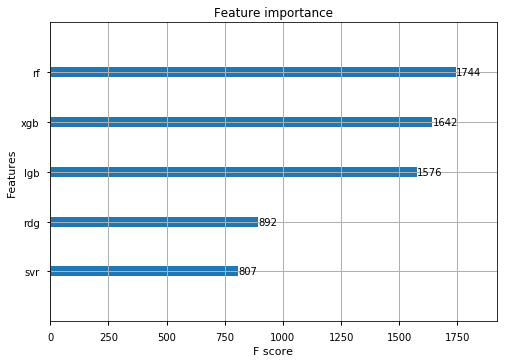

In [54]:
plot_importance(model);

The stacking model gives more importance to the predictions from the Random Forest model, as can be seen above, followed by XGBoost and LightGBM. 

#### Analysis of hyperparameters of best model

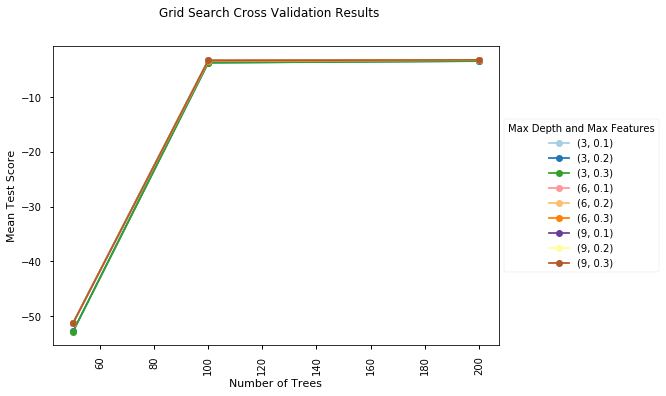

In [55]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results.copy().pivot_table(index='param_n_estimators',
                              columns=['param_max_depth','param_gamma'],
                              values='mean_test_score').plot(rot=90,
                                                             colormap='Paired',
                                                             marker='o').legend(loc='center left',
                                                                                title='Max Depth and Max Features',
                                                                                bbox_to_anchor=(1, 0.5))
plt.xlabel('Number of Trees')
plt.ylabel('Mean Test Score')
plt.suptitle('Grid Search Cross Validation Results');

Boosting performance does not improve beyond 100 rounds as can be seen above. However, we can see the performance is **marginally** better with **higher depth (9)** and **higher gamma (0.3)**.